### This notebook details the building of a CNN model that classifies ECG data (MIT-BIH).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The chosen dataset is the [the MIT-BIH Arrhythmia Dataset](https://www.physionet.org/physiobank/database/mitdb/) for this task.

### Importing the required libraries

In [ ]:
pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report,auc
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

import pydot
import graphviz
import random

import warnings
warnings.filterwarnings('ignore')

### Loading the training data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/MIT-BIH Arrhythmia Database /mitbih_train.csv',header=None)

In [ ]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train.shape

(87554, 188)

In [ ]:
df_train[187].unique()

array([0., 1., 2., 3., 4.])

The training data has 87554 rows & 188 columns. The target column is 187 with 5 classes – one class is the normal heart signal and other three are different signals corresponding to different heart diseases and last category is unknown beats:

0 — Non-ectopic beats (normal beat)      
1 — Supraventricular ectopic beats        
2 — Ventricular ectopic beats      
3 — Fusion beats          
4 — Unknown beats     

['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
class_names = ['N','S','V','F','Q']

### Loading the testing data

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/MIT-BIH Arrhythmia Database /mitbih_test.csv', header=None)

In [ ]:
df_test.shape

(21892, 188)

In [ ]:
df_test[187].unique()

array([0., 1., 2., 3., 4.])

The test data has 21892 rows & 188 columns. The last column (187) is the target variable with 5 classes.

In [ ]:
# Changing the target variable name for better readability
df_train = df_train.rename(columns = {187 : 'label'})
df_test = df_test.rename(columns = {187 : 'label'})

In [ ]:
# Also changing the data type for the label from float to integer
df_train['label'] = df_train['label'].astype('uint8')
df_test['label'] = df_test['label'].astype('uint8')

In [ ]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Looking at how the target variable is distributed in the training data: count and percentage

In [ ]:
#classes count
df_class=df_train['label'].value_counts()
print('Count of classes :\n',df_class)
#Percentages of class counts
per_class=df_train['label'].value_counts()/len(df_train)*100
print('percentage of count of classes :\n',per_class)

Count of classes :
 0    72471
4     6431
2     5788
1     2223
3      641
Name: label, dtype: int64
percentage of count of classes :
 0    82.772917
4     7.345181
2     6.610777
1     2.539005
3     0.732120
Name: label, dtype: float64


Text(0, 0.5, 'Index')

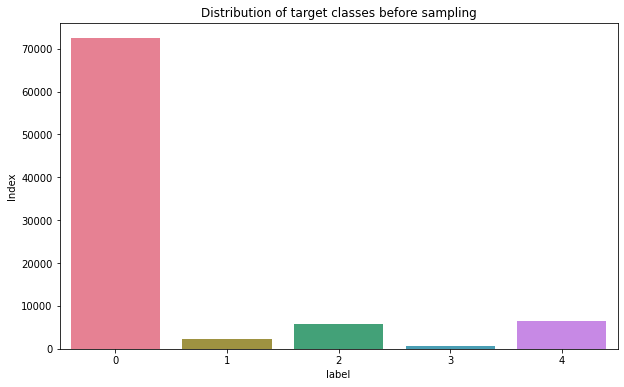

In [ ]:
#Countplot 
plt.figure(figsize=(10,6))
sns.countplot(df_train['label'],palette='husl')
plt.title('Distribution of target classes before sampling')
plt.xlabel('label')
plt.ylabel('Index')

In [ ]:
# Separating predictors and the target features; training data on 186 columns

# Train data
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

# Test data
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [ ]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
87549    4
87550    4
87551    4
87552    4
87553    4
Name: label, Length: 87554, dtype: uint8

It seems the classes in target variables are highly imbalanced. For balancing the classes I am using [SMOTE](https://arxiv.org/abs/1106.1813).

### **Handling imbalanced data**
Since the data is imbalanced, it needs to be balanced in order to achieve more accurate results from the ML model. To balance the data, I am using SMOTE (Synthetic Minority OverSampling Technique). SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

**This balancing should be done to the training data only if the classes are imbalanced.**

More details on [SMOTE](https://medium.com/analytics-vidhya/balance-your-data-using-smote-98e4d79fcddb)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter= Counter(y_train)
print(f'Before Sampling', counter)
# Oversampling the train data using SMOTE
smt=SMOTE()
X_train_sm,y_train_sm = smt.fit_resample(X_train,y_train)
counter= Counter(y_train_sm)
print('After Sampling', counter)

Before Sampling Counter({0: 72471, 4: 6431, 2: 5788, 1: 2223, 3: 641})
After Sampling Counter({0: 72471, 1: 72471, 2: 72471, 3: 72471, 4: 72471})


In [ ]:
X_train_sm

array([[0.97794116, 0.92647058, 0.68137252, ..., 0.        , 0.        ,
        0.        ],
       [0.96011394, 0.86324787, 0.46153846, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.65945947, 0.18648648, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.67567916, 0.65780446, ..., 0.        , 0.        ,
        0.        ],
       [0.91617313, 0.86842999, 0.81101113, ..., 0.        , 0.        ,
        0.        ],
       [0.75058532, 0.64986676, 0.53421823, ..., 0.        , 0.        ,
        0.        ]])

#### Distribution of target classes after using SMOTE sampling

Text(0, 0.5, 'Index')

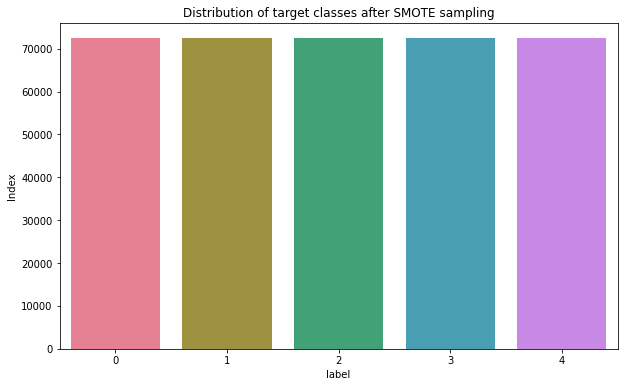

In [ ]:
#Countplot 
plt.figure(figsize=(10,6))
sns.countplot(y_train_sm, palette='husl')
plt.title('Distribution of target classes after SMOTE sampling')
plt.xlabel('label')
plt.ylabel('Index')

**A visual peek into different classes of heartbeats** 

In [ ]:
# Defining a function to plot class distribution
def class_distribution(df, class_label, index):
    # Creating a dataframe for class_label
    df = df[df.label== class_label]
    # Resetting the index
    df = df.reset_index(drop=True)
    # Dropping the label column from df
    df_new = df.drop('label',axis=1)
    # Considering
    df_array = df_new.loc[index,:]
    return df_array

Text(0, 0.5, 'Non-ectopic beats (normal beat)')

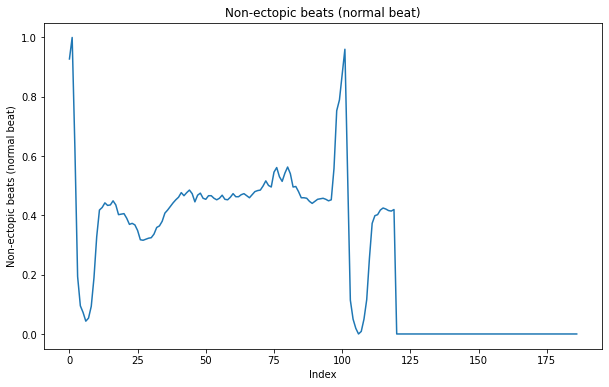

In [ ]:
# 0 — Non-ectopic beats (normal beat)
plt.figure(figsize = (10,6))
neb_df = class_distribution(df_train, 0 , 5) # Signal corressponding to the index 5 is considered for all plots
plt.plot(neb_df.index, neb_df.values)
plt.title('Non-ectopic beats (normal beat)')
plt.xlabel('Index')
plt.ylabel('Non-ectopic beats (normal beat)')

Text(0, 0.5, 'Supraventricular ectopic beats')

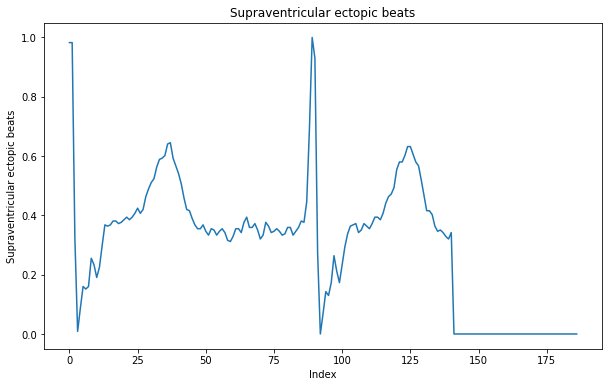

In [ ]:
# 1 — Supraventricular ectopic beats
plt.figure(figsize = (10,6))
seb_df = class_distribution(df_train, 1 , 5) # Signal corressponding to the index 5 is considered for all plots
plt.plot(seb_df.index, seb_df.values)
plt.title('Supraventricular ectopic beats')
plt.xlabel('Index')
plt.ylabel('Supraventricular ectopic beats')

Text(0, 0.5, 'Ventricular ectopic beats')

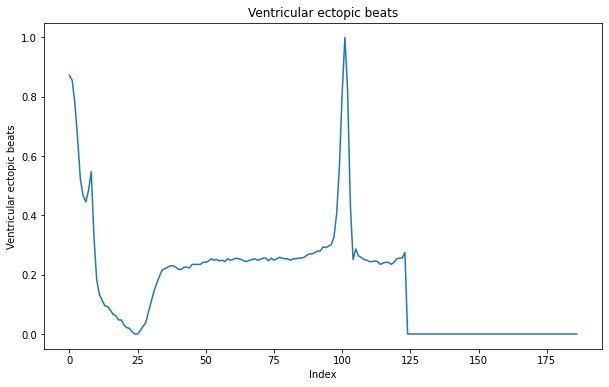

In [ ]:
# 2 — Ventricular ectopic beats
plt.figure(figsize = (10,6))
veb_df = class_distribution(df_train, 2 , 5) # Signal corressponding to the index 5 is considered for all plots
plt.plot(veb_df.index, veb_df.values)
plt.title('Ventricular ectopic beats')
plt.xlabel('Index')
plt.ylabel('Ventricular ectopic beats')

Text(0, 0.5, 'Fusion beats')

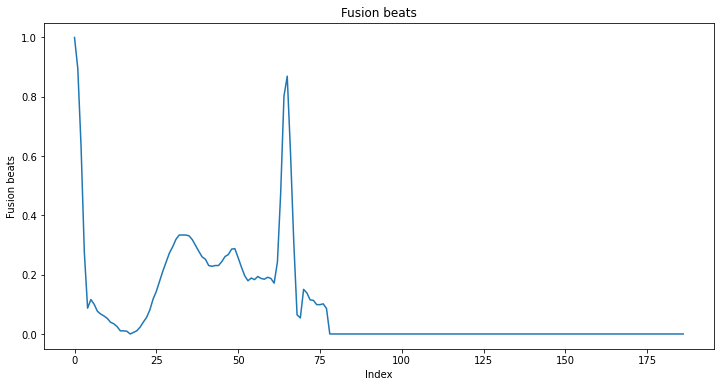

In [ ]:
# 3 — Fusion beats
plt.figure(figsize = (12,6))
fb_df = class_distribution(df_train, 3 , 5) # Signal corressponding to the index 5 is considered for all plots
plt.plot(fb_df.index, fb_df.values)
plt.title('Fusion beats')
plt.xlabel('Index')
plt.ylabel('Fusion beats')

Text(0, 0.5, 'Unknown beats')

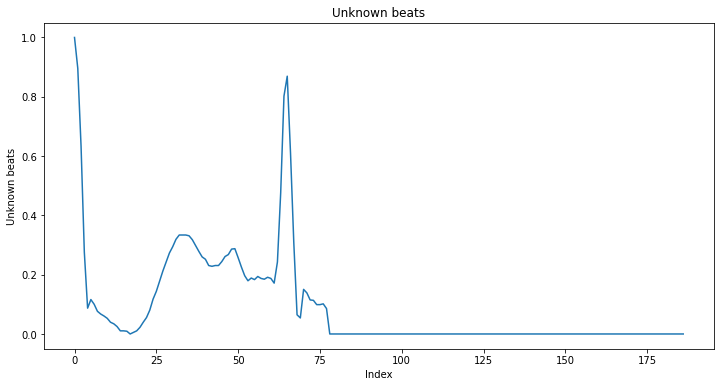

In [ ]:
# 4 — Unknown beats
plt.figure(figsize = (12,6))
ub_df = class_distribution(df_train, 3 , 5) # Signal corressponding to the index 5 is considered for all plots
plt.plot(ub_df.index, ub_df.values)
plt.title('Unknown beats')
plt.xlabel('Index')
plt.ylabel('Unknown beats')

#### Preprocessing

**Adding noise**   
Noise is added to the data to mimic the external random processes that can interfere in the data recording process. Additive white Gaussian noise (AWGN) model is  used for this task.

In [ ]:
# Adding some noise to increase efficiency of the trained model
def gaussian_noise(signal):
    noise = np.random.normal(0,0.05,187)
    return signal + noise
# Input to the model
X_train = X_train.values
# Adding noise
for i in range(X_train.shape[0]):
    X_train[i, :] = gaussian_noise(X_train[i, :])
    
# Convert X_train into dataframe
X_train = pd.DataFrame(X_train)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,1.131481,0.872671,0.620081,0.286674,0.139232,0.209557,0.098170,0.044483,0.019979,0.098112,0.058958,0.100932,0.032609,0.037730,0.081157,0.136586,0.032336,0.034421,0.125608,0.087634,0.083411,0.097766,0.088637,0.136626,0.079557,0.107027,0.111369,0.152846,0.140980,0.140601,0.246556,0.128483,0.211508,0.103290,0.172440,0.132324,0.142749,0.127397,0.054989,0.168425,...,-0.013704,0.031690,-0.053728,0.043260,0.031716,-0.059124,-0.045321,-0.052232,0.008248,-0.015858,0.088665,0.015640,-0.093608,-0.062379,0.024003,-0.005630,0.022386,0.101125,0.041591,-0.069238,0.005221,-0.001687,0.038786,0.042136,0.006937,0.016972,-0.026953,0.019174,-0.007722,-0.031242,0.009921,0.045775,0.009080,-0.099207,-0.042119,0.051150,0.022570,0.044641,-0.015573,0.029672
1,0.977723,0.832756,0.444049,0.244753,0.133353,0.035052,0.079242,0.165066,0.083300,0.075206,0.060300,0.054467,0.010965,0.112630,0.137969,0.060421,0.107137,0.091654,0.123181,0.051659,0.042367,0.012989,0.050075,0.049377,0.092770,0.123984,0.269762,0.193803,0.215214,0.242693,0.248221,0.293652,0.301182,0.345936,0.262633,0.278008,0.198211,0.216794,0.164013,0.114923,...,0.062502,-0.016626,0.014239,0.015566,-0.008673,-0.010982,-0.039283,-0.092037,-0.003681,0.009267,-0.007601,-0.041872,0.035855,0.060160,-0.038419,0.022616,-0.062206,-0.037923,-0.019460,-0.004799,0.050716,0.019517,0.053842,0.066068,-0.008404,-0.026809,0.001180,-0.046223,0.001993,-0.075203,-0.019381,0.087399,-0.006044,-0.011935,0.028397,0.007527,0.039733,0.046749,-0.081514,0.041261
2,1.038499,0.694875,0.155566,0.119314,0.056721,0.046266,0.083634,-0.035108,0.019914,-0.040847,0.102836,0.001447,0.070374,-0.011438,0.151074,0.071112,0.089597,0.092868,0.060927,0.218881,0.224393,0.083412,0.162301,0.209589,0.176650,0.275899,0.322445,0.385826,0.277569,0.354190,0.442157,0.258998,0.301635,0.216408,0.192553,0.146113,0.259346,0.033481,0.033667,0.080768,...,-0.008726,0.006362,-0.018619,-0.087370,0.027337,0.038499,-0.007227,0.017236,-0.079030,-0.048785,0.093266,0.073284,-0.041428,0.014916,-0.006734,0.079889,-0.014226,0.116488,-0.018881,-0.035405,0.075850,-0.001105,0.017550,-0.017759,0.044102,0.061793,-0.044498,0.034150,0.007797,-0.031072,0.044570,-0.058583,0.023876,-0.006476,-0.058531,0.006065,-0.004769,0.021678,-0.011961,-0.067459
3,0.983646,0.767630,0.506983,0.289872,0.105935,0.069177,0.104816,0.076149,0.065783,0.111193,0.056405,0.006342,0.075899,0.043386,0.186985,0.194655,0.194596,0.168206,0.139647,0.084914,0.069363,0.140002,0.100308,0.041471,0.089961,0.198823,0.158916,0.163237,0.180871,0.065165,0.154667,0.123817,0.025465,0.003218,0.085881,0.038822,0.026308,-0.008007,0.044680,-0.006367,...,-0.021179,-0.047903,0.051452,-0.113187,0.016346,0.004173,0.035616,0.065479,-0.066772,0.000307,0.012482,-0.018872,0.044559,0.013825,0.076845,-0.065581,-0.012318,0.027724,0.039926,0.049790,0.021924,0.022447,0.023239,-0.042725,-0.070756,-0.059200,0.036209,-0.053689,-0.047340,0.064227,-0.106928,-0.036602,-0.001605,0.023342,0.046480,0.075223,0.013600,0.021718,-0.034510,0.068375
4,0.920340,0.950694,0.845409,0.632547,0.308572,0.247269,0.128222,0.104974,0.082914,0.276260,0.113738,0.145236,0.110332,0.268521,0.151923,0.090044,0.188244,0.167106,0.188905,0.124235,0.185781,0.199485,0.139379,0.172309,0.166144,0.196818,0.248902,0.337316,0.306271,0.136680,0.168596,0.163496,0.167017,0.202146,0.246880,0.257883,0.175370,0.221990,0.219783,0.132988,...,0.083096,-0.064375,-0.107446,0.037056,0.024888,0.052583,-0.103183,0.038567,-0.132565,0.137570,0.004338,-0.017945,-0.075342,-0.096408,-0.001516,-0.016385,0.026263,0.058429,0.013224,0.060016,0.028493,-0.097955,0.023472,0.002371,0.001169,-0.025518,0.026837,0.041880,0.092296,-0.107415,-0.025794,0.015989,0.010267,0.104646,0.021511,0.068039,-0.026708,0.006056,-0.027981,-0.040658

In [ ]:
#Split data into train set(80%) & test set (20%)
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

**Following is a sample signal with added noise**

In [ ]:
x_sample = X_train.loc[5,:]
x_original = df_train.drop('label',axis=1).loc[5,:]

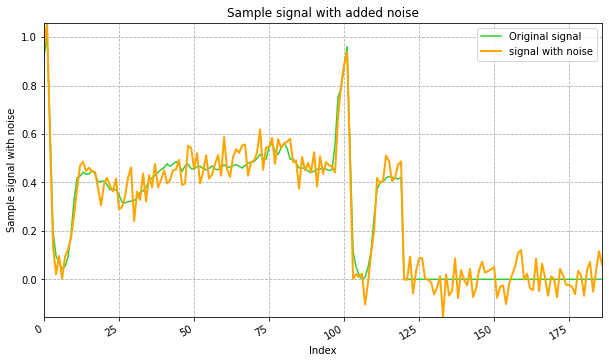

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(x_original.index, x_original.values, color = 'limegreen', label='Original signal')
plt.plot(x_sample.index, x_sample.values,color='orange', label='signal with noise',linewidth=2)
plt.title('Sample signal with added noise')
plt.xlabel('Index')
plt.ylabel('Sample signal with noise')

plt.gcf().autofmt_xdate()   # Beautify the x-labels
plt.autoscale(tight=True)
 
plt.legend(loc='best')
plt.grid(True, linestyle='dashed')

### Encoding the target classes with One hot coding

In [ ]:
# One hot encoding the output of the model
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train.shape

(70043, 5)

In [ ]:
X_train.shape

(70043, 187)

In [ ]:
# Convert to numpy arrays
x_train = np.array(X_train)
x_val = np.array(X_val)
x_test = np.array(X_test)

In [ ]:
x_test

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        0.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        0.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        0.        ]])

Reshaping the X_train, & X_test from (n_samples, n_features) to (n_samples, number of time steps, n_features): CNN input format

In [ ]:
x_train.shape[0]

70043

In [ ]:
x_train.shape[1]

187

In [ ]:
X_train =x_train.reshape(x_train.shape[0], 1, x_train.shape[1])   # number of time steps is 1
X_val =x_val.reshape(x_val.shape[0], 1, x_val.shape[1])   # number of time steps is 1
X_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # number of time steps is 1

In [ ]:
n_classes = y_train.shape[1]
n_classes

5

## Building the CNN model

The model has three Convolution1D layers & two Dropout layers. Followed by 2 Dense layers, two of which have the ReLU activation function, the last layer has 5 nodes, corresponding to the 5 output class labels, with a Softmax activation function.   
The softmax activation function is used when the outputs given to train are one hot encoded as this function turns a vector of n values into a vector with n values that sum to 1, thus representing the probability of each class represented by the n values.

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(1, 187)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))    # Fully connected layer
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))    # Fully connected layer
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
# Compile model
model.compile(optimizer = Adam(0.0001), 
                loss = 'categorical_crossentropy', 
                metrics = ['accuracy'])

In [ ]:
print('Model summary')
print(model.summary())

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 128)            71936     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 64)             4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)

### Plotting the Model

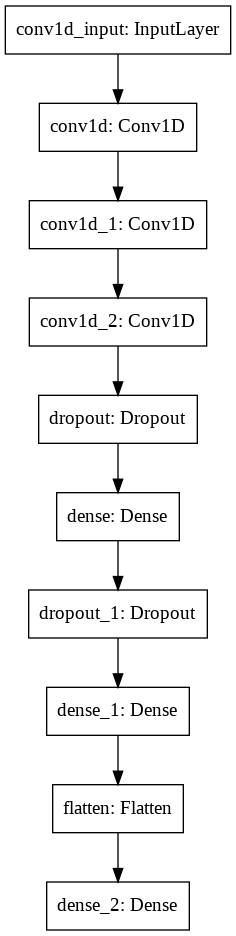

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model).create(prog='dot', format='png'))

### Training the model

In [ ]:
batch_size = 16

history=model.fit(X_train, y_train, batch_size=batch_size,epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
4378/4378 [==============================] - 30s 3ms/step - loss: 0.7179 - accuracy: 0.8318 - val_loss: 0.3206 - val_accuracy: 0.9113
Epoch 2/20
4378/4378 [==============================] - 15s 3ms/step - loss: 0.3391 - accuracy: 0.9074 - val_loss: 0.2484 - val_accuracy: 0.9347
Epoch 3/20
4378/4378 [==============================] - 14s 3ms/step - loss: 0.2692 - accuracy: 0.9295 - val_loss: 0.2215 - val_accuracy: 0.9402
Epoch 4/20
4378/4378 [==============================] - 14s 3ms/step - loss: 0.2300 - accuracy: 0.9386 - val_loss: 0.1987 - val_accuracy: 0.9434
Epoch 5/20
4378/4378 [==============================] - 14s 3ms/step - loss: 0.2112 - accuracy: 0.9430 - val_loss: 0.1800 - val_accuracy: 0.9475
Epoch 6/20
4378/4378 [==============================] - 17s 4ms/step - loss: 0.1952 - accuracy: 0.9443 - val_loss: 0.1737 - val_accuracy: 0.9543
Epoch 7/20
4378/4378 [==============================] - 16s 4ms/step - loss: 0.1795 - accuracy: 0.9498 - val_loss: 0.1645 - val_ac

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


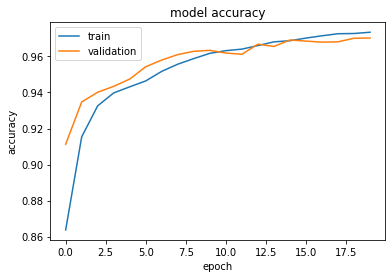

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

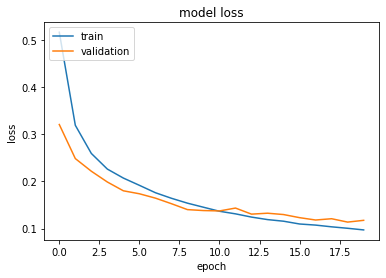

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model performance on test data

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[9.9922836e-01, 7.7106536e-04, 4.3015018e-07, 9.9087970e-08,
        2.0029526e-08],
       [9.6079195e-01, 3.3432733e-02, 3.3719956e-03, 1.5566224e-03,
        8.4669149e-04],
       [9.7666430e-01, 1.9954281e-02, 1.1873778e-03, 1.2864494e-03,
        9.0772350e-04],
       ...,
       [5.4642726e-02, 2.7764577e-03, 5.2984811e-02, 1.8461625e-03,
        8.8774991e-01],
       [4.2531330e-09, 3.6886016e-13, 1.6415665e-08, 1.0108237e-14,
        1.0000000e+00],
       [2.8530978e-10, 4.9767942e-15, 9.0932428e-10, 8.4317690e-17,
        1.0000000e+00]], dtype=float32)

In [ ]:
# Convert class probabilities to classes
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
y_test = y_test.argmax(axis=1)
y_test

array([0, 0, 0, ..., 4, 4, 4])

### Confusion matrix

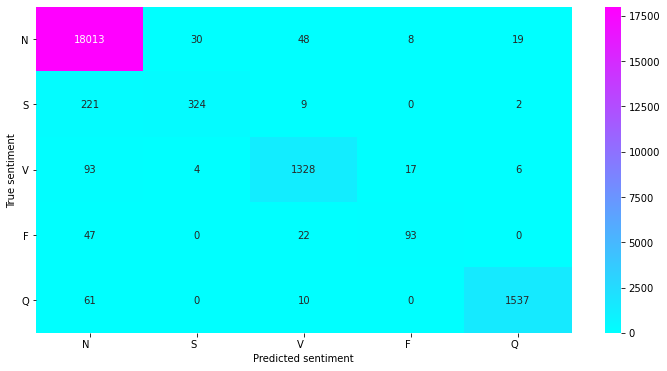

In [ ]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(12,6))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="cool")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification Report

In [ ]:
class_report= classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18118
           1       0.91      0.58      0.71       556
           2       0.94      0.92      0.93      1448
           3       0.79      0.57      0.66       162
           4       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.92      0.80      0.85     21892
weighted avg       0.97      0.97      0.97     21892



I achieved an **accuracy of 0.97 & f1_score of 0.97** on the testsing data.

In [ ]:
# Binarize the targets & predictions to plot PR & ROC curves
y_test= label_binarize(y_test, classes=[*range(n_classes)])
y_pred = label_binarize(y_pred, classes=[*range(n_classes)])

For imbalanced dataset, **the precision-recall curve & ROC curve** are better metrics for evaluating our model performance.

### Plot PR (Precision-Recall) curve:

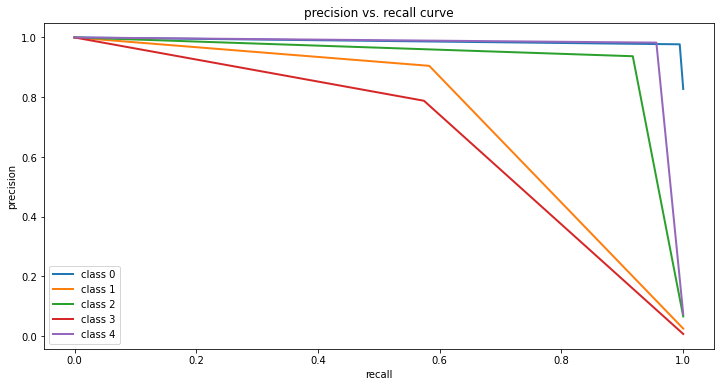

In [ ]:
# plot model precision-recall curve
precision = dict()
recall = dict()
plt.figure(figsize=(12,6))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

### ROC (Receiver operating characterstic) curve:

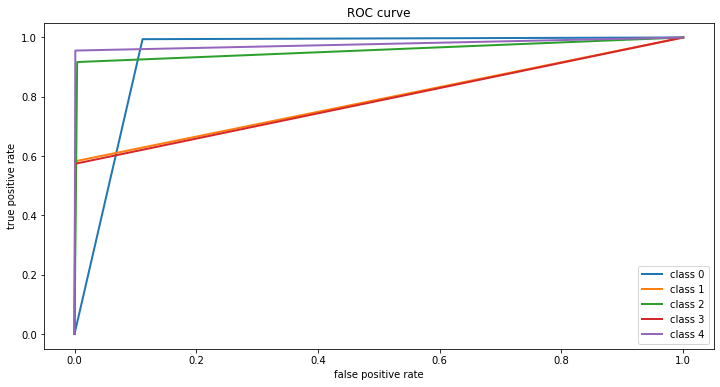

In [ ]:
# plot roc curve
fpr = dict()
tpr = dict()

plt.figure(figsize=(12,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

Insights:
* Based on the precision_recall curve & roc_curve, the model is clearly having difficulties in predicting class 1 & class 3 correctly.

### Model prediction on a random signal

Now randomly visualizing one of the heartbeat signals whilst performing predictions using our model.

Actual label:  N
Model prediction :  N  with probability  0.9993333


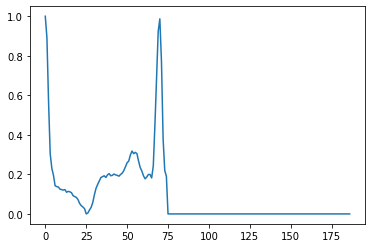

In [ ]:
i = random.randint(0, len(X_test)-1)
output = model(np.expand_dims(X_test[i], 0))
x_random = pd.DataFrame(X_test[i])
x_random = x_random.loc[0,:]
pred = output.numpy()[0]
plt.plot(x_random.index, x_random.values)
print("Actual label: ", class_names[np.argmax(y_test[i])])
print("Model prediction : ", class_names[np.argmax(pred)],
      " with probability ", pred[np.argmax(pred)])